# Deep Learning Demo for Time Series with aeon


### Overview

Deep learning is proven to be very effective for Time Series Classification (TSC) tasks after the extensive experiments done in [1], especially Convolution based architectures i.e. FCN and ResNet [2]. A while later, InceptionTime (Convolution based) was proposed to become the new state-of-the-art deep learning model for TSC [3]. In [4], new hand-crafted convolution filters were proposed to boost InceptionTime. The model proposed in [4], Hybrid InceptionTime (H-InceptionTime) is currently, at the time of writing, the state-of-the-art deep learning model for TSC.

More recently, in the latest Time Series Regression (TSER) review [5], the deep learning model InceptionTime is seen to be the state-of-the-art deep learning model.

Moreover, deep learning models seem to work quite well to solve the Time Series Clustering task (TSCL).
The models are from the deep learning clustering bake off [7] (more models from that bake off will soon be in aeon).

In this demo, we cover the usage of the deep learning models for both TSC, TSCL and TSER.

Soon we plan to include more tasks into the deep learning domain suchas Time Series Forecasting.

### Contents

1. Imports
2. Classification
    - InceptionTime
    - H-InceptionTime
3. Regression
    - InceptionTime
4. Clustering
    - Auto-Encoder Fully Convolutional Network
5. Saving and Loading model
6. Deep Learning for any time series task
7. References

### 1. Imports

Import the deep learning models for classification and regression, the data loader and InceptionNetwork.

In [1]:
import os

# avoid imports warning for tensorflow
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import warnings

# avoid packages warnings such as sklearn
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# skip future tensorflow warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.decomposition import PCA
from tensorflow.keras import backend as k

from aeon.classification.deep_learning import FCNClassifier, InceptionTimeClassifier
from aeon.clustering.deep_learning import AEFCNClusterer
from aeon.datasets import load_classification, load_regression
from aeon.networks import InceptionNetwork
from aeon.regression.deep_learning import InceptionTimeRegressor

### 2. Classification

#### InceptionTime

The InceptionTime model is an ensemble of multiple (by default five) Inception models. Each Inception model is a Convolutional Neural Network made of six Inception modules as seen in the Figure below. Each Inception module is composed of multiple (by default three) convolution layer in parallel and a max-pooling operation as well.
![InceptionTime](./img/Inception.png)

In [2]:
xtrain, ytrain = load_classification(name="ArrowHead", split="train")
xtest, ytest = load_classification(name="ArrowHead", split="test")

inc = InceptionTimeClassifier(n_classifiers=5, use_custom_filters=False, n_epochs=3)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

2023-10-06 17:31:12.574639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


3/3 [==============================] - 0s 86ms/step
Predictions:  ['0' '0' '0' '0' '0']
Ground Truth:  ['0' '0' '0' '0' '0']


#### H-InceptionTime

Just as InceptionTime, H-InceptionTime is an ensemble of multiple H-Inception models. The model can be seen in the figure below, where the additional custom filters are added in parallel to the first Inception module.
![H-InceptionTime](./img/H-Inception.png)

The usage of H-InceptionTime can be done by setting the ```use_custom_filters``` flag to True. This is the default setup, not setting this flag to True will results in using the H-InceptionTime by default and only by setting it to False that InceptionTime is used.

In [3]:
xtrain, ytrain = load_classification(name="ArrowHead", split="train")
xtest, ytest = load_classification(name="ArrowHead", split="test")

inc = InceptionTimeClassifier(n_classifiers=5, use_custom_filters=True, n_epochs=3)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

3/3 [==============================] - 0s 54ms/step
Predictions:  ['0' '0' '0' '0' '0']
Ground Truth:  ['0' '0' '0' '0' '0']


### 3. Regression

#### InceptionTime

As for classification, the InceptionTime model for TSR tasks is an ensemble of five different Inception models. The difference here is just in the last layer where the number of output neurons is one and no activation is used. The loss function used in this case is the Mean Squared Error.

In [4]:
xtrain, ytrain = load_regression(name="Covid3Month", split="train")
xtest, ytest = load_regression(name="Covid3Month", split="test")

inc = InceptionTimeRegressor(n_regressors=5, n_epochs=1, use_custom_filters=False)
inc.fit(X=xtrain, y=ytrain)
ypred = inc.predict(X=xtest)

print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])

1/1 [==============================] - 0s 209ms/step
Predictions:  [-0.23141143 -0.0241483  -0.01730516 -0.34630919 -3.14292431]
Ground Truth:  [0.0118838  0.00379507 0.08298755 0.04510921 0.12783075]


### 4. Clustering

#### Auto-Encoder Fully Convolutional Network

For this model, we adapted the idea in [7] to construct a simple auto-encoder model with the Fully Convolutional Network (FCN) [2] as backbone for the encoder and decoder architectures. Simply the decoder is the symetrical version of the encoder (FCN) with the usage of Convolution1DTranspose instead of normal Convolution1D layers. The auto-encoder is trained to correcly reconstruct the input time series in order to learn a clustering task in the latent representations (between encoder and decoder).

The AEFCNClusterer can be used in many ways, first of all, you can control whether your latent space is time series space or Euclidean space.
This is done by setting the `temporal_latent_space` flag to `True` or `False`.

Given that the AEFCNClusterer learns the clustering task in the latent space, then a clustering algorithm should be defined, this is done by passing it as string value to thr `clustering_algorithm` parameter. Modifying the clustering algorithm parameters is possible throught a dictionary parameter `clustering_params`.

To train the model, simply call the `fit()` function which will train the auto-encoder followed by training the clustering algorithm in the latent space.

In what follows we show two examples in using AEFCNClusterer.

In [5]:
xtrain, _ = load_classification(name="ArrowHead", split="train")
xtest, ytest = load_classification(name="ArrowHead", split="test")

aefcn = AEFCNClusterer(
    n_clusters=2,
    temporal_latent_space=False,
    clustering_algorithm="kmeans",
    n_epochs=10,
)

aefcn.fit(X=xtrain)
ypred = aefcn.predict(X=xtest)
print("Predictions: ", ypred[0:5])
print("Ground Truth: ", ytest[0:5])
print()
print("Score : ", aefcn.score(X=xtest))

6/6 [==============================] - 0s 25ms/step
Predictions:  [0 1 0 0 0]
Ground Truth:  ['0' '0' '0' '0' '0']

6/6 [==============================] - 0s 32ms/step
Score :  -701.7947322426963


### 5. Saving and Loading Model

#### Saving model

While training a deep learning model with `aeon`, a default callback is used to save the best model during training based on the training loss. This saved model is then loaded to use for evaluation and deleted once no longer used. This intermediate step is to avoid saving the model to file when the user is not in need of it later. This however can be changed by setting the `save_best_model` flag to True. The default name for the model is "best_model" with a `.keras` extension and will be saved in the default working directory. To change this, simply change the `file_path` and `best_file_name` parameters to your preference.

The same settings can be used if the user needs to save the last model during training as well. This is done by simply setting the flag `save_last_model` to True. The name of this saved model can be set by changing the `last_file_name` parameter and the `file_path` as well.

Here is an example on saving the best and last models of an FCN model:

In [6]:
xtrain, ytrain = load_classification(name="ArrowHead", split="train")
xtest, ytest = load_classification(name="ArrowHead", split="test")

fcn = FCNClassifier(
    save_best_model=True,
    save_last_model=True,
    file_path="./",
    best_file_name="best_fcn",
    last_file_name="last_fcn",
    n_epochs=2,
)

# The following is commented to avoid CI doing the saving for no reason

# fcn.fit(X=xtrain, y=ytrain)
# ypred = fcn.predict(X=xtest)

### 6. Deep Learning for any time series task

Suppose you want to use a single Inception Network, for example to perform some self-supervised learning.  This is simple in aeon because of the structure on the network module. You can create any of model to perform any task using any of the Neural Networks in the module.

In this Example we will be re-creating the TRILITE Self-Supervised Learning model from [6]. This model uses a deep learning encoder coupled with a triplet loss mechanism to learn a compact latent representation of the time series data. This model require a loss that is not pre-implented in deep learning frameworks (such as tensorflow, aeon's deep learning backend) and a triplets generation technique.
The approach uses the loss and triplets to optimizer the parameters of a deep learning encoder so aeon can be used to create this encoder's architecture and the rest is from the user side as in the rest of this example.

In [7]:
# define self-supervised space dimension

n_dim = 16

# load the data

xtrain, ytrain = load_classification(name="ArrowHead", split="train")
xtest, ytest = load_classification(name="ArrowHead", split="test")

# Flip axis to be handled correctly in tensorflow

xtrain = np.transpose(xtrain, axes=(0, 2, 1))
xtest = np.transpose(xtest, axes=(0, 2, 1))

Now define the triplet loss needed for the SSL model. Taken from [5].

In [8]:
def triplet_loss_function(alpha):
    def temp(ytrue, ypred):
        ref = ypred[:, :, 0]
        pos = ypred[:, :, 1]
        neg = ypred[:, :, 2]

        ref = k.cast(ref, dtype=ref.dtype)
        pos = k.cast(pos, dtype=ref.dtype)
        neg = k.cast(neg, dtype=ref.dtype)

        loss = k.maximum(
            k.sum(
                tf.math.subtract(
                    tf.math.add(k.square(ref - pos), alpha), k.square(ref - neg)
                ),
                axis=1,
            ),
            0,
        )

        return loss

    return temp

Now define the network with the output self-supervised projection layer.

In [16]:
# Define the triplets input layers


input_ref_layer = tf.keras.layers.Input(xtrain.shape[1:])
input_pos_layer = tf.keras.layers.Input(xtrain.shape[1:])
input_neg_layer = tf.keras.layers.Input(xtrain.shape[1:])

inc_network = InceptionNetwork()
input_layer, gap_layer = inc_network.build_network(input_shape=xtrain.shape[1:])

encoder = tf.keras.models.Model(inputs=input_layer, outputs=gap_layer)

output_layer_ref = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_ref_layer))
)
output_layer_pos = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_pos_layer))
)
output_layer_neg = tf.keras.layers.Reshape(target_shape=(-1, 1))(
    tf.keras.layers.Dense(units=n_dim)(encoder(input_neg_layer))
)

output_layer = tf.keras.layers.Concatenate(axis=-1)(
    [output_layer_ref, output_layer_pos, output_layer_neg]
)

SSL_model = tf.keras.models.Model(
    inputs=[input_ref_layer, input_pos_layer, input_neg_layer], outputs=output_layer
)

SSL_model.compile(loss=triplet_loss_function(alpha=1e-5))

Define your triplets beforehand

In [10]:
def triplet_generation(x):
    w1 = np.random.choice(np.linspace(start=0.6, stop=1, num=1000), size=1)
    w2 = (1 - w1) / 2

    ref = np.random.permutation(x[:])

    n = int(ref.shape[0])

    pos = np.zeros(shape=ref.shape)
    neg = np.zeros(shape=ref.shape)

    all_indices = np.arange(start=0, stop=n)

    for i in range(n):
        temp_indices = np.delete(arr=all_indices, obj=i)
        indice_neg = int(np.random.choice(temp_indices, size=1))

        temp_indices = np.delete(arr=all_indices, obj=[i, indice_neg])
        indice_b = int(np.random.choice(temp_indices, size=1))

        indice_c = int(np.random.choice(temp_indices, size=1))

        indice_b2 = int(np.random.choice(temp_indices, size=1))

        indice_c2 = int(np.random.choice(temp_indices, size=1))

        a = ref[i].copy()

        nota = ref[indice_neg].copy()

        b = ref[indice_b].copy()
        c = ref[indice_c].copy()

        b2 = ref[indice_b2].copy()
        c2 = ref[indice_c2].copy()

        # MixingUp

        pos[i] = w1 * a + w2 * b + w2 * c
        neg[i] = w1 * nota + w2 * b2 + w2 * c2

    return ref, pos, neg

Generate the triplets

In [17]:
xtrain_ref, xtrain_pos, xtrain_neg = triplet_generation(x=xtrain)

Set the model's callbacks

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=50, min_lr=0.0001
)

file_path = "./best_ssl_model.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path, monitor="loss", save_best_only=True
)

callbacks = [reduce_lr, model_checkpoint]

Train your model

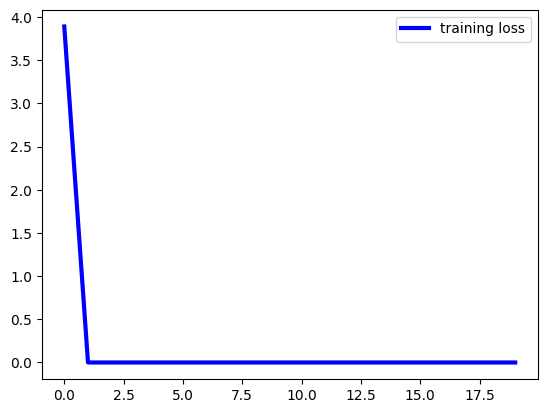

In [19]:
history = SSL_model.fit(
    [xtrain_ref, xtrain_pos, xtrain_neg],
    np.zeros(shape=len(xtrain)),
    epochs=20,
    callbacks=callbacks,
    verbose=False,
)

plt.figure()
plt.plot(history.history["loss"], lw=3, color="blue", label="training loss")
plt.legend()
plt.show()

Plot the 2D representation of the train data now

2/2 [==============================] - 1s 10ms/step


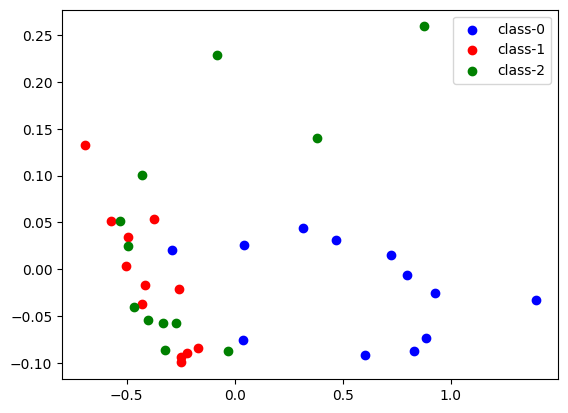

In [20]:
plt.cla()
plt.clf()
plt.close()
plt.figure()

pca = PCA(n_components=2)

# load best model
model = tf.keras.models.load_model("./best_ssl_model.keras", compile=False)
latent_space = model.predict([xtrain, xtrain, xtrain])
latent_space = latent_space[:, :, 0]

pca.fit(latent_space)
latent_space_2d = pca.transform(latent_space)

colors = ["blue", "red", "green"]

for c in range(len(np.unique(ytrain))):
    plt.scatter(
        latent_space_2d[ytrain.astype(np.int64) == c][:, 0],
        latent_space_2d[ytrain.astype(np.int64) == c][:, 1],
        color=colors[c],
        label="class-" + str(c),
    )


plt.legend()
plt.show()

In [21]:
os.remove("./best_ssl_model.keras")

### 7. References

- [1] Ismail Fawaz, Hassan, et al. "Deep learning for time series classification: a
    review." Data mining and knowledge discovery 33.4 (2019): 917-963.
- [2] Wang, Zhiguang et al. "Time series classification from scratch with deep neural
    networks: A strong baseline." 2017 International joint conference on neural networks (IJCNN). IEEE, 2017.
- [3] Ismail Fawaz, Hassan, et al. "Inceptiontime: Finding alexnet for time series
    classification." Data Mining and Knowledge Discovery 34.6 (2020): 1936-1962.
- [4] Ismail-Fawaz, Ali, et al. "Deep Learning For Time Series Classification Using New
    Hand-Crafted Convolution Filters." International Conference on Big Data. IEEE, (2022).
- [5] Guijo-Rubio, David, et al. "Unsupervised Feature Based Algorithms for Time Series
    Extrinsic Regression." arXiv preprint arXiv:2305.01429 (2023).
- [6] Ismail-Fawaz, Ali, et al. "Enhancing Time Series Classification with Self-Supervised Learning."
    International Conference on Agents and Artificial Intelligence ICAART (2023).
- [7] Lafabregue, Baptiste, et al. "End-to-end deep representation learning for time series clustering:
    a comparative study." Data Mining and Knowledge Discovery 36.1 (2022): 29-81.